#Paquetes necesarios

In [20]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt


TAREA 1: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



In [38]:
# Carga la imagen de las monedas con fondo ruidoso
img = cv2.imread('Monedas.jpg')

# Convertimos la imagen a escala de grises
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gris_eq = cv2.equalizeHist(img_gris)

#Dos variantes de umbralizado. 
umbral = 150 # Prueba varios comenzando en 130

# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


contornos_redondos = []
diametros_monedas = []

# Aplicar un suavizado Gaussiano para eliminar el ruido antes de la detección de contornos
img_blur = cv2.GaussianBlur(img_th2, (5, 5), 0)


# Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_blur, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

# Dibuja sobre la imagen de entrada los contornos en verde
# Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

valor_inicial = 10.5
print(f"La compra es de {valor_inicial}€")

# Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_blur, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada solo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)



# Dibuja contornos externos rellenos en imagen vacía
# Imagen negra
img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

# Recorre los contornos externos
for c in contornos2:
    # Área del contorno
    area = cv2.contourArea(c)
    # Área mínima (útil filtrar en ocasiones)
    if area > 300:
        # Perímetro del contorno
        perimetro = cv2.arcLength(c,True)

        # Calcular la relación entre el área y el cuadrado del perímetro
        relacion_redondez = (4 * np.pi * area) / (perimetro ** 2)
    
        # Define un umbral más alto para asegurar que sean solo bordes redondos
        umbral_redondez = 0.80
        if relacion_redondez > umbral_redondez:
            contornos_redondos.append(c)

            # Encuentra el círculo que mejor se ajusta al contorno de cada moneda y calcula su diámetro.

            (x, y), radio = cv2.minEnclosingCircle(c)

            # Calcula el diámetro a partir del radio
            diametro = 2 * radio
            diametros_monedas.append(diametro)

            # Dibuja los contornos redondos filtrados
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)


# Variable global para almacenar el valor total seleccionado
valor_total_seleccionado = 0.0

# Función para manejar el clic del usuario en la imagen
def seleccionar_moneda(event, x, y, flags, param):
    global diametro_seleccionado, valor_total_seleccionado
    if event == cv2.EVENT_LBUTTONDOWN:
        for c in contornos_redondos:
            # Dice si el punto donde el usuario hizo clic está dentro de un contorno.

            if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                # Encuentra el círculo que mejor se ajusta al contorno
                (cx, cy), radio = cv2.minEnclosingCircle(c)
                diametro_seleccionado = 2 * radio
                
                # Identificar el valor de la moneda
                diametro_mm = diametro_seleccionado / relacion_pixel_mm
                valor_moneda = identificar_moneda(diametro_mm)

                # Imprimir el valor de la moneda junto con su diámetro en píxeles
                print(f"Moneda seleccionada: {valor_moneda}€, Diámetro en mm: {diametro_mm:.2f}")
                
                # Sumar el valor de la moneda al total acumulado
                valor_total_seleccionado += valor_moneda
                
                if valor_total_seleccionado >= valor_inicial:
                    # Imprimir el valor total acumulado
                    print(f"Compra exitosa: {valor_total_seleccionado:.2f}€")
                    if valor_total_seleccionado > valor_inicial:

                        print(f"El cambio es: {valor_total_seleccionado-valor_inicial:.2f}€")
                

#Compara el diámetro de la moneda detectada con los diámetros conocidos de las monedas para identificar su valor

tolerancia = 0.6
def identificar_moneda(diametro_mm):
    if abs(diametro_mm - 16.25) < tolerancia:
        return 0.01  # 1 céntimo
    elif abs(diametro_mm - 18.75) < tolerancia:
        return 0.02  # 2 céntimos
    elif abs(diametro_mm - 21.25) < tolerancia:
        return 0.05  # 5 céntimos
    elif abs(diametro_mm - 19.75) < tolerancia:
        return 0.10  # 10 céntimos
    elif abs(diametro_mm - 22.25) < tolerancia:
        return 0.20  # 20 céntimos
    elif abs(diametro_mm - 24.35) < tolerancia:
        return 0.50  # 50 céntimos
    elif abs(diametro_mm - 23.25) < tolerancia:
        return 1.0  # 1 Euro
    elif abs(diametro_mm - 25.75) < tolerancia:
        return 2.0  # 2 Euros
    return 0.0  # No es una moneda válida



# Variable para almacenar la cantidad de cada tipo de moneda detectada

monedas_detectadas = {
    0.01: 0,
    0.02: 0,
    0.05: 0,
    0.10: 0,
    0.20: 0,
    0.50: 0,
    1.00: 0,
    2.00: 0
}

# Mostrar imagen para la selección de una moneda

cv2.namedWindow("Seleccione una moneda haciendo clic", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Seleccione una moneda haciendo clic", 800, 600)
cv2.imshow("Seleccione una moneda haciendo clic", img_rgb)
cv2.setMouseCallback("Seleccione una moneda haciendo clic", seleccionar_moneda)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Asumir que se ha seleccionado una moneda con un diámetro conocido
diametro_seleccionado_mm = 23.25  # Para una moneda de 1 Euro

# Esta relación convierte los diámetros medidos en píxeles a unidades físicas (milímetros), lo compara con diametro de 1€ para determinar el valor.

relacion_pixel_mm = diametro_seleccionado / diametro_seleccionado_mm
print(f"Relación píxeles/mm: {relacion_pixel_mm}")

# Recorre los diámetros de todas las monedas detectadas para identifica su valor, y por otro lado suma el total.

valor_total = 0
for diametro in diametros_monedas:
    diametro_mm = diametro / relacion_pixel_mm
    valor_moneda = identificar_moneda(diametro_mm)
    valor_total += valor_moneda
    # Si la moneda es válida, incrementar el conteo en el diccionario
    if valor_moneda in monedas_detectadas:
        monedas_detectadas[valor_moneda] += 1

# Mostrar el número de monedas y el valor total
print(f"Monedas detectadas: {len(diametros_monedas)}")
print(f"Cantidad total de dinero: {valor_total:.2f}€")


# Imprimir las monedas clasificadas por tipo
print("\nMonedas clasificadas:")
for valor, cantidad in monedas_detectadas.items():
    if cantidad > 0:
        print(f"{cantidad} moneda(s) de {valor}€")



plt.show()

La compra es de 10.5€
Moneda seleccionada: 2.0€, Diámetro en mm: 25.89
Moneda seleccionada: 0.05€, Diámetro en mm: 21.22
Moneda seleccionada: 2.0€, Diámetro en mm: 25.89
Moneda seleccionada: 2.0€, Diámetro en mm: 25.89
Moneda seleccionada: 2.0€, Diámetro en mm: 25.89
Moneda seleccionada: 2.0€, Diámetro en mm: 25.89
Moneda seleccionada: 0.5€, Diámetro en mm: 24.21
Compra exitosa: 10.55€
El cambio es: 0.05€
Relación píxeles/mm: 8.691886655745968
Monedas detectadas: 8
Cantidad total de dinero: 1.80€

Monedas clasificadas:
1 moneda(s) de 0.01€
2 moneda(s) de 0.02€
1 moneda(s) de 0.05€
1 moneda(s) de 0.2€
1 moneda(s) de 0.5€
1 moneda(s) de 1.0€


TAREA 2: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


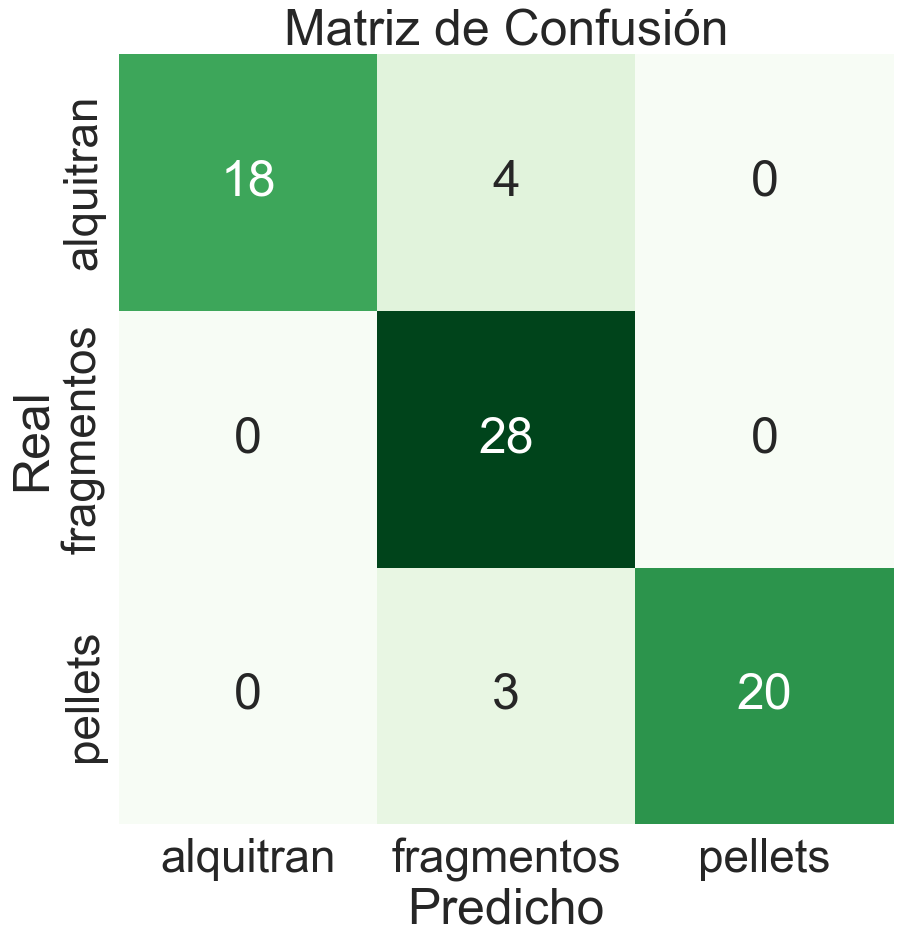


Informe de Clasificación:
Clase: alquitran
  Precisión: 1.00
  Recall: 0.82
  F1-Score: 0.90

Clase: fragmentos
  Precisión: 0.80
  Recall: 1.00
  F1-Score: 0.89

Clase: pellets
  Precisión: 1.00
  Recall: 0.87
  F1-Score: 0.93

Clase: macro avg
  Precisión: 0.93
  Recall: 0.90
  F1-Score: 0.91

Clase: weighted avg
  Precisión: 0.92
  Recall: 0.90
  F1-Score: 0.91



In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler

# Cargar imágenes sin redimensionar
imagenes = {
    'fragmentos': cv2.imread('FRA.png'),
    'pellets': cv2.imread('PEL.png'),
    'alquitran': cv2.imread('TAR.png')
}

# Preprocesamiento de imágenes
def procesar_imagen(imagen):
    escala_grises = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    desenfoque = cv2.GaussianBlur(escala_grises, (5, 5), 0)
    _, umbral = cv2.threshold(desenfoque, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return umbral

# Extraer características geométricas y visuales
def obtener_caracteristicas(contorno, imagen_gris):
    # Área y perímetro del contorno
    area = cv2.contourArea(contorno)
    perimetro = cv2.arcLength(contorno, True)
    compacidad = (perimetro ** 2) / area if area != 0 else 0
    
    # Relación área de partícula/área del contenedor
    x, y, w, h = cv2.boundingRect(contorno)
    relacion_area_contenedor = area / (w * h) if w * h != 0 else 0
    
    # Relación ancho-alto (relación de aspecto)
    relacion_aspecto = float(w) / h if h != 0 else 0
    
    # Ajuste elíptico para calcular ejes
    elipse = cv2.fitEllipse(contorno) if len(contorno) >= 5 else None
    eje_mayor = max(elipse[1]) if elipse else 0
    eje_menor = min(elipse[1]) if elipse else 0
    relacion_ejes = eje_mayor / eje_menor if eje_menor != 0 else 0
    
    # Convexidad y solidez
    casco = cv2.convexHull(contorno)
    area_casco = cv2.contourArea(casco)
    solidez = float(area) / area_casco if area_casco != 0 else 0
    
    # Distancias centroide-contorno (máxima y mínima)
    momentos = cv2.moments(contorno)
    if momentos['m00'] != 0:
        cx = int(momentos['m10'] / momentos['m00'])
        cy = int(momentos['m01'] / momentos['m00'])
        distancias = [cv2.pointPolygonTest(contorno, (cx, cy), True) for pt in contorno]
        distancia_max = max(distancias) if distancias else 0
        distancia_min = min(distancias) if distancias else 0
        relacion_distancias = distancia_min / distancia_max if distancia_max != 0 else 0
    else:
        relacion_distancias = 0
    
    # Características de textura (histograma reducido a 16 bins)
    mascara = np.zeros(imagen_gris.shape, dtype="uint8")
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    region_mascara = cv2.bitwise_and(imagen_gris, imagen_gris, mask=mascara)
    histograma = cv2.calcHist([region_mascara], [0], mascara, [16], [0, 256])  # Histograma con 16 bins
    histograma = cv2.normalize(histograma, histograma).flatten()
    
    # Devolver todas las características
    return [area, perimetro, compacidad, relacion_area_contenedor, 
            relacion_aspecto, relacion_ejes, solidez, relacion_distancias] + histograma.tolist()

# Aumento de datos
def aumento_datos(imagen):
    return [
        imagen,
        cv2.flip(imagen, 1),  # Volteo horizontal
        cv2.warpAffine(imagen, cv2.getRotationMatrix2D((imagen.shape[1] // 2, imagen.shape[0] // 2), 15, 1), 
                       (imagen.shape[1], imagen.shape[0])),  # Rotación +15 grados
        cv2.warpAffine(imagen, cv2.getRotationMatrix2D((imagen.shape[1] // 2, imagen.shape[0] // 2), -15, 1), 
                       (imagen.shape[1], imagen.shape[0])),  # Rotación -15 grados
        cv2.convertScaleAbs(imagen, alpha=1.2),  # Ajuste de brillo
        cv2.convertScaleAbs(imagen, alpha=0.8),  # Ajuste de brillo
        cv2.GaussianBlur(imagen, (5, 5), 0)  # Desenfoque
    ]

# Procesamiento de imágenes y extracción de características
def procesar_y_extraer_caracteristicas(etiqueta, imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    umbral = procesar_imagen(imagen)
    contornos, _ = cv2.findContours(umbral, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    data = []

    etiquetas = []
    for contorno in contornos:
        if cv2.contourArea(contorno) > 5:
            caracteristicas = obtener_caracteristicas(contorno, imagen_gris)
            data.append(caracteristicas)
            etiquetas.append(etiqueta)
    
    return data, etiquetas

# Aumentación y procesamiento de imágenes
resultados = []
for etiqueta, imagen in imagenes.items():
    imagenes_aumentadas = aumento_datos(imagen)
    for imagen_aug in imagenes_aumentadas:
        resultados.append(procesar_y_extraer_caracteristicas(etiqueta, imagen_aug))

# Unir datos y etiquetas
datos = [item for sublista in resultados for item in sublista[0]]
etiquetas = [item for sublista in resultados for item in sublista[1]]

# Crear un DataFrame
columnas = ['Area', 'Perimetro', 'Compacidad', 'Rel_Area_Contenedor', 'Rel_Aspecto', 
            'Rel_Ejes', 'Solidez', 'Rel_Distancias'] + [f'Hist_{i}' for i in range(16)]
df = pd.DataFrame(datos, columns=columnas)
df['Etiqueta'] = etiquetas

# Separar los datos en conjunto de entrenamiento y prueba
X = df.drop('Etiqueta', axis=1)
y = df['Etiqueta']
X_entrenar, X_prueba, y_entrenar, y_prueba = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_entrenar, y_entrenar)

# Predecir y evaluar el modelo
y_pred = modelo_rf.predict(X_prueba)
matriz_de_confusion = confusion_matrix(y_prueba, y_pred)
informe_clasificacion = classification_report(y_prueba, y_pred, output_dict=True)

# Mostrar matriz de confusión
plt.figure(figsize=(10, 10))
sns.heatmap(matriz_de_confusion, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=modelo_rf.classes_, yticklabels=modelo_rf.classes_)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar métricas por clase
print("\nInforme de Clasificación:")
for clase, metricas in informe_clasificacion.items():
    if isinstance(metricas, dict):  # Evitar los promedios globales
        print(f"Clase: {clase}")
        print(f"  Precisión: {metricas['precision']:.2f}")
        print(f"  Recall: {metricas['recall']:.2f}")
        print(f"  F1-Score: {metricas['f1-score']:.2f}\n")